# Importing libraries

In [1]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=0fa0d3d329fee64ac8cdfcf6659ca1804b0119b30be0069182724a41bd66cd45
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
# nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
import spacy

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

import joblib
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/colab_bangkit/Rahayu Sentiment Analysis/'

In [6]:
# Read datasets
df_train = pd.read_csv(base_path +  'data/test.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv(base_path +  'data/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv(base_path +  'data/test.txt', names=['Text', 'Emotion'], sep=';')

In [7]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [8]:
df_train.drop(df_train[df_train.Emotion == 'surprise'].index, inplace = True)
df_val.drop(df_val[df_val.Emotion == 'surprise'].index, inplace = True)
df_test.drop(df_test[df_test.Emotion == 'surprise'].index, inplace = True)

In [9]:
#print the shape of the data set
print(df_train.shape)

(1934, 2)


In [10]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [11]:
#print the shape of the data set
print(df_test.shape)

(1934, 2)


In [12]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [13]:
#print the shape of the data set
print(df_val.shape)

(1919, 2)


# A Glimpse On Data

## Train dataset

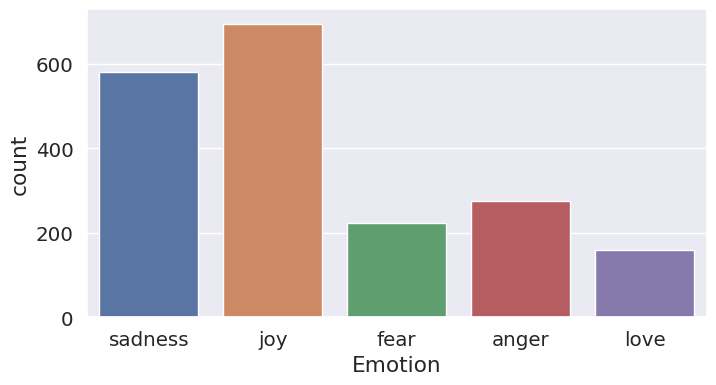

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

The data is imbalanced so, we may try to balance it but i choose to keep it first

### Save Stop Words set as Object

In [ ]:
# load stopwords
stop_words = set(stopwords.words("english"))

In [22]:
# saving
with open('stop_words.pkl', 'wb') as handle:
    pickle.dump(stop_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

# try to load
with open('stop_words.pkl', 'rb') as handle:
    stop_words = pickle.load(handle)

## Test dataset

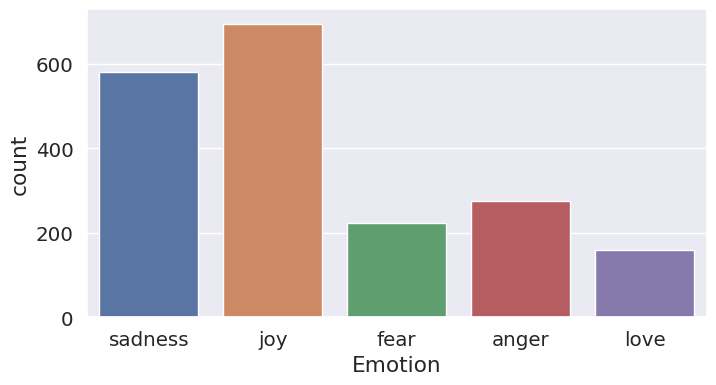

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

## Validation dataset

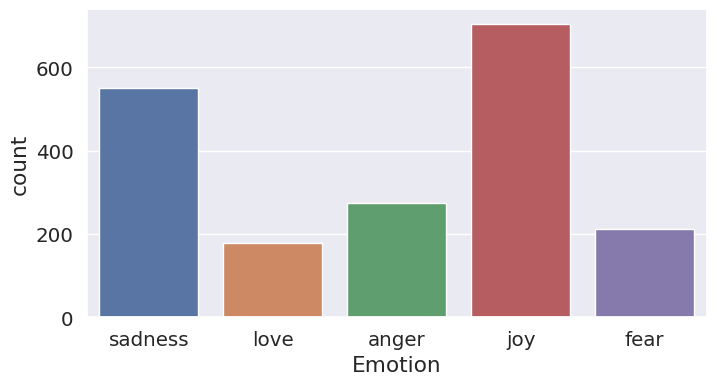

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

## Preparing Function for Cleaning

In [41]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence



In [111]:
normalized_sentence("The dogs are playing @ the park21.")


'dog play park'

In [44]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

## Modeling

### TF-IDF


We will start by baseline models

**Creating a pipline using tf-idf for words embedding and different models.**


In [45]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [46]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.

    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.

    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [47]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.

    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.

    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

### Logistic Regression

**Training the Logistic Regression model on the Training set**


In [48]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [49]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [50]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8366080661840745 



,F1 score
sadness,0.814655
joy,0.761644
fear,0.855377
anger,0.369231
love,0.916803


In [51]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       1.00      0.69      0.81       275
        fear       0.99      0.62      0.76       224
         joy       0.75      1.00      0.86       695
        love       1.00      0.23      0.37       159
     sadness       0.87      0.97      0.92       581

    accuracy                           0.84      1934
   macro avg       0.92      0.70      0.74      1934
weighted avg       0.87      0.84      0.82      1934



### Decision Tree

**Training the Decision Tree model on the Training set**

In [52]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  1.0 



,F1 score
sadness,1.0
joy,1.0
fear,1.0
anger,1.0
love,1.0


In [53]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       275
        fear       1.00      1.00      1.00       224
         joy       1.00      1.00      1.00       695
        love       1.00      1.00      1.00       159
     sadness       1.00      1.00      1.00       581

    accuracy                           1.00      1934
   macro avg       1.00      1.00      1.00      1934
weighted avg       1.00      1.00      1.00      1934



### Support Vector Machine

**Training the Support Vector Machine model on the Training set**


In [54]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])


Accuracy:  0.9901758014477766 



,F1 score
sadness,0.998179
joy,0.995516
fear,0.988620
anger,0.947020
love,0.997425


In [55]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       275
        fear       1.00      0.99      1.00       224
         joy       0.98      1.00      0.99       695
        love       1.00      0.90      0.95       159
     sadness       0.99      1.00      1.00       581

    accuracy                           0.99      1934
   macro avg       0.99      0.98      0.99      1934
weighted avg       0.99      0.99      0.99      1934



### Random Forest

**Training the Random Forest model on the Training set**

In [56]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  1.0 



,F1 score
sadness,1.0
joy,1.0
fear,1.0
anger,1.0
love,1.0


In [57]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       275
        fear       1.00      1.00      1.00       224
         joy       1.00      1.00      1.00       695
        love       1.00      1.00      1.00       159
     sadness       1.00      1.00      1.00       581

    accuracy                           1.00      1934
   macro avg       1.00      1.00      1.00      1934
weighted avg       1.00      1.00      1.00      1934



## Results ??

In [58]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Decision Tree,1.00
1,Random Forest,1.00
2,Support Vector Machine,0.99
3,Logistic Regression,0.84


actually we can achive the great accuracy using decision tree, but because we in Bangkit need to use tensorflow and Deep Learning so we also develop our LSTM Model

# Better way?
Word embedding using this glove and use a sequance model

## Text Preprocessing

In [60]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [61]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

### Save Label Encoder as Object

In [62]:
# saving
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [63]:
#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4}


In [64]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [65]:
print(y_train)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


## Tokenizing

In [66]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')


In [67]:
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

### Save Tokenizer as Object

In [68]:
import pickle

# saving
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [69]:
# loading
with open('tokenizer.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [110]:
sentence= 'I am really tired with the workload that never end, this work is really tire me out everday.'
normalize = normalized_sentence(sentence)

word_index = tokenizer.word_index
print(normalize)
tokens = loaded_tokenizer.texts_to_sequences([normalize])
tokens

really tired workload never end work really tire everday


[[11, 322, 1, 74, 85, 32, 11, 1, 1]]

In [79]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding


In [81]:
df_test.shape

(1934, 2)

In [82]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

213

In [83]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 3790


In [84]:
#before
sequences_train[0]

[3, 5, 2, 168, 377, 3, 5, 1703, 42]

In [85]:
#after
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Word Embedding

In [88]:
# Read GloVE embeddings
# you can download the embeddings from glove project website : https://nlp.stanford.edu/projects/glove/

path_to_glove_file = base_path + '/pretrained-embedding/english/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

In [93]:
# Read word vectors
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 10962 words (405 misses)


## Modeling

In [94]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          758000    
                                                                 
 bidirectional (Bidirectiona  (None, 229, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 229, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                        

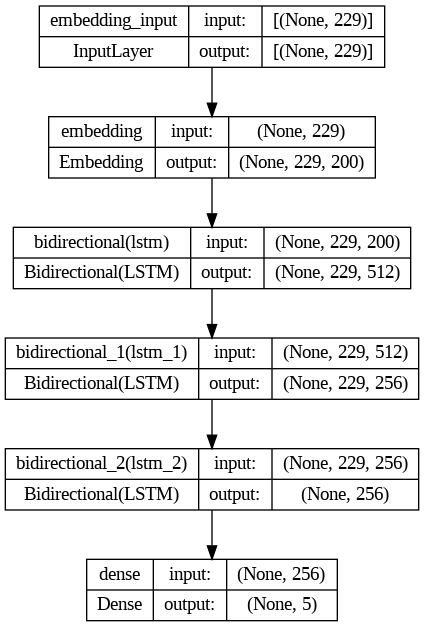

In [95]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [96]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [97]:
# Fit model
  history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
8/8 [==============================] - 89s 8s/step - loss: 1.5876 - accuracy: 0.3433 - val_loss: 1.3921 - val_accuracy: 0.5143
Epoch 2/30
8/8 [==============================] - 58s 7s/step - loss: 1.2712 - accuracy: 0.5222 - val_loss: 1.1628 - val_accuracy: 0.5576
Epoch 3/30
8/8 [==============================] - 56s 7s/step - loss: 1.1072 - accuracy: 0.5646 - val_loss: 1.0077 - val_accuracy: 0.6197
Epoch 4/30
8/8 [==============================] - 58s 7s/step - loss: 0.9438 - accuracy: 0.6458 - val_loss: 0.9342 - val_accuracy: 0.6656
Epoch 5/30
8/8 [==============================] - 55s 7s/step - loss: 0.7764 - accuracy: 0.7311 - val_loss: 0.8592 - val_accuracy: 0.6828
Epoch 6/30
8/8 [==============================] - 59s 8s/step - loss: 0.5943 - accuracy: 0.7921 - val_loss: 0.7057 - val_accuracy: 0.7470
Epoch 7/30
8/8 [==============================] - 57s 7s/step - loss: 0.4518 - accuracy: 0.8423 - val_loss: 0.7507 - val_accuracy: 0.7439
Epoch 8/30
8/8 [==================

In [98]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

60/60 [==============================] - 34s 575ms/step - loss: 0.5987 - accuracy: 0.8044


[0.5986679792404175, 0.8043818473815918]

In [99]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1)

61/61 [==============================] - 31s 495ms/step - loss: 0.1933 - accuracy: 0.9426


[0.1932721734046936, 0.9426059722900391]

In [100]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

61/61 [==============================] - 33s 522ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       275
           1       0.96      0.95      0.95       224
           2       0.98      0.95      0.96       695
           3       0.81      0.89      0.85       159
           4       0.97      0.94      0.95       581

    accuracy                           0.94      1934
   macro avg       0.92      0.94      0.93      1934
weighted avg       0.95      0.94      0.94      1934



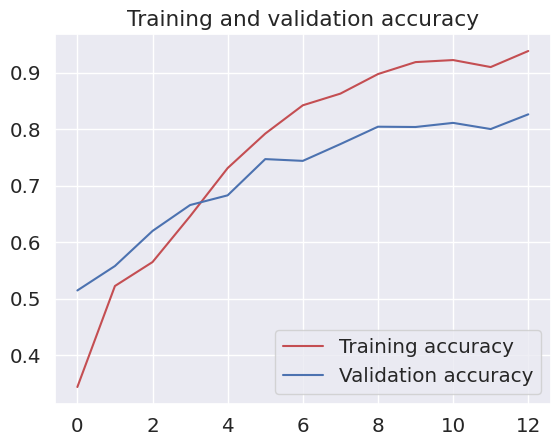

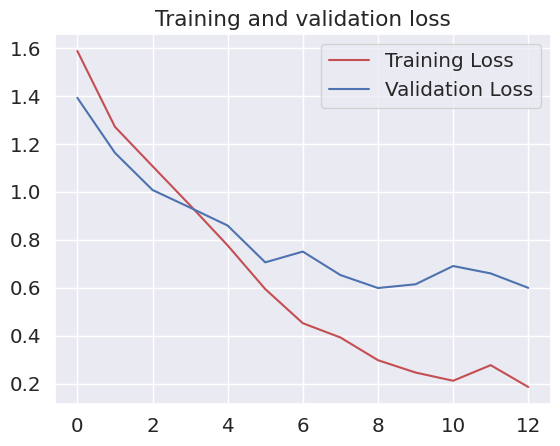

In [101]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]

for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 1s 1s/step
joy : 0.28089630603790283


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 1s 529ms/step
anger : 0.35092365741729736


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 1s 708ms/step
sadness : 0.8052964210510254


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 418ms/step
joy : 0.9286251664161682




In [103]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

my old brother is dead
1/1 [==============================] - 0s 381ms/step
anger : 0.9232573509216309




In [104]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

Im feeling sad today
1/1 [==============================] - 1s 760ms/step
sadness : 0.985833466053009




In [105]:
# model.save(base_path + 'Bidirectional LSTM English EMO.h5')

# Save Model


In [106]:
joblib.dump(model, 'Bidirectional LSTM English EMO.pkl')

['Bidirectional LSTM English EMO.pkl']

In [107]:
loaded_model = joblib.load(base_path + 'Bidirectional LSTM English EMO.pkl')

In [108]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(loaded_model.predict(sentence), axis=-1))[0]
proba =  np.max(loaded_model.predict(sentence))
print(f"{result} : {proba}\n\n")

Im feeling sad today
1/1 [==============================] - 1s 536ms/step
love : 0.8139813542366028




In [109]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence = 'my old brother is dead'

# Normalisasi kalimat
normalize = normalized_sentence(sentence)
print(normalize)

# loading Token
with open('tokenizer.pkl', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Tokenisasi kalimat
word_index = loaded_tokenizer.word_index

tokens = loaded_tokenizer.texts_to_sequences([normalize])
print(tokens)

# Padding kalimat
pad = pad_sequences(tokens, maxlen=229, truncating='pre')
print(pad)

# Prediksi hasil
# loading
with open('label_encoder.pkl', 'rb') as handle:
    le = pickle.load(handle)
result = le.inverse_transform(np.argmax(loaded_model.predict(pad), axis=-1))[0]
proba = np.max(loaded_model.predict(pad))
print(f"{result} : {proba}\n\n")


old brother dead
[[229, 822, 2129]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  